## OCR of License Plates

Dataset Source: https://www.kaggle.com/datasets/nickyazdani/license-plate-text-recognition-dataset

##### Install Necessary Libraries

In [47]:
%pip install --upgrade pip
%pip install torch torchvision torchaudio
%pip install -q datasets jiwer

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


##### Import Necessary Libraries

In [48]:
import os, sys, itertools
os.environ['TOKENIZERS_PARALLELISM']='false'

import pandas as pd
from sklearn.model_selection import train_test_split

from PIL import Image

import torch
from torch.utils.data import Dataset

import datasets
from datasets import load_dataset

import transformers
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import VisionEncoderDecoderModel, TrOCRProcessor, default_data_collator

import evaluate

##### Display Versions of Relevant Software & Libraries

In [49]:
print("Python:".rjust(15), sys.version[0:6])
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)

        Python: 3.9.7 
        Pandas: 1.4.4
      Datasets: 2.4.0
  Transformers: 4.21.3
         Torch: 1.12.1


##### Ingest, Preprocess, & Split Dataset (into Training & Testing Datasets)

In [50]:
path = "/Users/leedunn/Desktop/Projects to Train/OCR LP Text Recognition/lpr.csv"

dataset = pd.read_csv(path)

dataset.drop(columns=["Unnamed: 0"], inplace=True)
dataset.rename(columns={"images" : "file_name", "labels" : "text"}, inplace=True)

# train/test split
train_dataset, test_dataset = train_test_split(dataset, train_size=0.80, random_state=42)

train_dataset.reset_index(drop=True, inplace=True)
test_dataset.reset_index(drop=True, inplace=True)

print(train_dataset.info())
print(test_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  16000 non-null  object
 1   text       16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  4000 non-null   object
 1   text       4000 non-null   object
dtypes: object(2)
memory usage: 62.6+ KB
None


##### Show First Samples in DataFrame

In [51]:
train_dataset.head(12)

,file_name,text
0,19994.jpg,2730UB
1,16385.jpg,2124SA
2,25271.jpg,D56501
3,23041.jpg,NK8918
4,20167.jpg,5362HT
5,19736.jpg,HW1723
6,12907.jpg,9683PA
7,21581.jpg,5172QB
8,21036.jpg,N58328
9,1821.jpg,0574EU


##### Create Dataset Class

In [52]:
class License_Plates_OCR_Dataset(Dataset):
    
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, padding="max_length", max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id 
                  else -100 for label in labels]
        
        encoding = {"pixel_values" : pixel_values.squeeze(), "labels" : torch.tensor(labels)}
        return encoding

##### Basic Values/Constants

In [53]:
MODEL_CKPT = "microsoft/trocr-base-printed"
MODEL_NAME =  MODEL_CKPT.split("/")[-1] + "_license_plates_ocr"
NUM_OF_EPOCHS = 2

##### Instantiate Processor, Create Training, & Testing Dataset Instances

In [54]:
processor = TrOCRProcessor.from_pretrained(MODEL_CKPT)

train_ds = License_Plates_OCR_Dataset(root_dir="/Users/leedunn/Desktop/Projects to Train/OCR LP Text Recognition/cropped_lps/cropped_lps/",
                             df=train_dataset,
                             processor=processor)

test_ds = License_Plates_OCR_Dataset(root_dir="/Users/leedunn/Desktop/Projects to Train/OCR LP Text Recognition/cropped_lps/cropped_lps/",
                             df=test_dataset,
                             processor=processor)

loading feature extractor configuration file https://huggingface.co/microsoft/trocr-base-printed/resolve/main/preprocessor_config.json from cache at /Users/leedunn/.cache/huggingface/transformers/832950d3437b5e524332931523cb1fc015003d2d55692b5f8ef437d253ad17dd.3ce3b627e98330dd48cd2a0c208fd2bda7a8a77f12b4253b922d1c1ce40e01a3
Feature extractor ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 384
}

loading file https://huggingface.co/microsoft/trocr-base-printed/resolve/main/vocab.json from cache at /Users/leedunn/.cache/huggingface/transformers/fda4022f9ad7b6db6decb3cef7525279bd3702e076ff5d3a435fb5ae63b107d6.647b4548b6d9ea817e82e7a9231a320231a1c9ea24053cc9e758f3fe68216f05
loading file https://huggingface.co/microsoft/trocr-base-printed/resolve/main/merges.txt from cache at /Users/leedunn/.cache/hu

##### Print Length of Training & Testing Datasets

In [55]:
print(f"The training dataset has {len(train_ds)} samples in it.")
print(f"The testing dataset has {len(test_ds)} samples in it.")

The training dataset has 16000 samples in it.
The testing dataset has 4000 samples in it.


##### Example of Input Data Shapes

In [56]:
encoding = train_ds[0]

for k,v in encoding.items():
    print(k, " : ", v.shape)

pixel_values  :  torch.Size([3, 384, 384])
labels  :  torch.Size([128])


##### Show Example

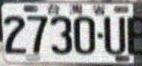

In [57]:
image = Image.open(train_ds.root_dir + train_dataset['file_name'][0]).convert("RGB")

image

##### Show Label for Above Example

In [58]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

2730UB


#### Instantiate Model

In [59]:
model = VisionEncoderDecoderModel.from_pretrained(MODEL_CKPT)

loading configuration file https://huggingface.co/microsoft/trocr-base-printed/resolve/main/config.json from cache at /Users/leedunn/.cache/huggingface/transformers/212ce944385c924d9d9f37e30c9e9c23414582ec39b2d99b6acc7e19fc372f86.d59848aae48f9ec6eaf5caa5ded0a5e1660ddc8202561ca823851ada5344c39f
Model config VisionEncoderDecoderConfig {
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "",
    "activation_dropout": 0.0,
    "activation_function": "gelu",
    "add_cross_attention": true,
    "architectures": null,
    "attention_dropout": 0.0,
    "bad_words_ids": null,
    "bos_token_id": 0,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": 0.0,
    "cross_attention_hidden_size": 768,
    "d_model": 1024,
    "decoder_attention_heads": 16,
    "decoder_ffn_dim": 4096,
    "decoder_layerdrop": 0.0,
    "decoder_layers": 12,
    "decoder_start_token_id": 2,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "dropout": 0.1,
    "e

##### Model Configuration Modifications

In [60]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

model.config.vocab_size = model.config.decoder.vocab_size

model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

##### Define Metrics Evaluation

In [61]:
cer_metric = evaluate.load("cer")

def compute_metrics(pred):
    label_ids = pred.label_ids
    pred_ids = pred.predictions
    
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)
    
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    
    return {"cer" : cer}

##### Define Training Arguments

In [62]:
args = Seq2SeqTrainingArguments(
    output_dir = MODEL_NAME,
    num_train_epochs=NUM_OF_EPOCHS,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_first_step=True,
    hub_private_repo=True,
    push_to_hub=True
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


##### Define Trainer

In [64]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=args,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=default_data_collator
)

Cloning https://huggingface.co/DunnBC22/trocr-base-printed_license_plates_ocr into local empty directory.


##### Fit/Train Model

In [65]:
train_results = trainer.train()

/Users/leedunn/Documents/nlpnn/nlp/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 16000
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4000


  0%|          | 0/4000 [00:00<?, ?it/s]

{'loss': 9.7097, 'learning_rate': 4.99875e-05, 'epoch': 0.0}
{'loss': 0.7791, 'learning_rate': 4.375e-05, 'epoch': 0.25}
{'loss': 0.5107, 'learning_rate': 3.7500000000000003e-05, 'epoch': 0.5}
{'loss': 0.3557, 'learning_rate': 3.125e-05, 'epoch': 0.75}
{'loss': 0.3144, 'learning_rate': 2.5e-05, 'epoch': 1.0}


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8


  0%|          | 0/500 [00:00<?, ?it/s]

Saving model checkpoint to trocr-base-printed_license_plates_ocr/checkpoint-2000
Configuration saved in trocr-base-printed_license_plates_ocr/checkpoint-2000/config.json


{'eval_loss': 0.24631145596504211, 'eval_cer': 0.04733333333333333, 'eval_runtime': 55301.7054, 'eval_samples_per_second': 0.072, 'eval_steps_per_second': 0.009, 'epoch': 1.0}


Model weights saved in trocr-base-printed_license_plates_ocr/checkpoint-2000/pytorch_model.bin
Feature extractor saved in trocr-base-printed_license_plates_ocr/checkpoint-2000/preprocessor_config.json
Feature extractor saved in trocr-base-printed_license_plates_ocr/preprocessor_config.json
Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.


{'loss': 0.2086, 'learning_rate': 1.8750000000000002e-05, 'epoch': 1.25}
{'loss': 0.1776, 'learning_rate': 1.25e-05, 'epoch': 1.5}
{'loss': 0.1802, 'learning_rate': 6.25e-06, 'epoch': 1.75}
{'loss': 0.143, 'learning_rate': 0.0, 'epoch': 2.0}


***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8


  0%|          | 0/500 [00:00<?, ?it/s]

Saving model checkpoint to trocr-base-printed_license_plates_ocr/checkpoint-4000
Configuration saved in trocr-base-printed_license_plates_ocr/checkpoint-4000/config.json


{'eval_loss': 0.15811479091644287, 'eval_cer': 0.036833333333333336, 'eval_runtime': 54648.5441, 'eval_samples_per_second': 0.073, 'eval_steps_per_second': 0.009, 'epoch': 2.0}


Model weights saved in trocr-base-printed_license_plates_ocr/checkpoint-4000/pytorch_model.bin
Feature extractor saved in trocr-base-printed_license_plates_ocr/checkpoint-4000/preprocessor_config.json
Feature extractor saved in trocr-base-printed_license_plates_ocr/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 774109.7161, 'train_samples_per_second': 0.041, 'train_steps_per_second': 0.005, 'train_loss': 0.3358841931819916, 'epoch': 2.0}


##### Save Model & Training Metrics

In [66]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Saving model checkpoint to trocr-base-printed_license_plates_ocr
Configuration saved in trocr-base-printed_license_plates_ocr/config.json
Model weights saved in trocr-base-printed_license_plates_ocr/pytorch_model.bin
Feature extractor saved in trocr-base-printed_license_plates_ocr/preprocessor_config.json
Saving model checkpoint to trocr-base-printed_license_plates_ocr
Configuration saved in trocr-base-printed_license_plates_ocr/config.json
Model weights saved in trocr-base-printed_license_plates_ocr/pytorch_model.bin
Feature extractor saved in trocr-base-printed_license_plates_ocr/preprocessor_config.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 32.0k/1.24G [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/trocr-base-printed_license_plates_ocr
   2ea0ec3..f8584da  main -> main



***** train metrics *****
  epoch                    =                 2.0
  train_loss               =              0.3359
  train_runtime            = 8 days, 23:01:49.71
  train_samples_per_second =               0.041
  train_steps_per_second   =               0.005


##### Evaluate Model

In [67]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8


  0%|          | 0/500 [00:00<?, ?it/s]

***** eval metrics *****
  epoch                   =         2.0
  eval_cer                =      0.0368
  eval_loss               =      0.1581
  eval_runtime            = 15:19:38.93
  eval_samples_per_second =       0.072
  eval_steps_per_second   =       0.009


##### Push Model to Hub (My Profile!!!)

In [68]:
kwargs = {
    "finetuned_from" : model.config._name_or_path,
    "tasks" : "image-to-text",
    "tags" : ["image-to-text"],
}

if args.push_to_hub:
    trainer.push_to_hub("All Dunn!!!")
else:
    trainer.create_model_card(**kwargs)

Saving model checkpoint to trocr-base-printed_license_plates_ocr
Configuration saved in trocr-base-printed_license_plates_ocr/config.json
Model weights saved in trocr-base-printed_license_plates_ocr/pytorch_model.bin
Feature extractor saved in trocr-base-printed_license_plates_ocr/preprocessor_config.json


Upload file .DS_Store: 100%|##########| 6.00k/6.00k [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/trocr-base-printed_license_plates_ocr
   f8584da..3b058e3  main -> main



### Notes & Other Takeaways From This Project
****
- The results were pretty good. I was pondering whether to train for 2 or 3 epochs. Ultimately, I trained this model for 2 epochs. If this were a work project (where multiprocessing and other options are available), I would have trained for 3, if not 4, epochs.
****

### Citations

##### For Transformer Checkpoint
- @misc{li2021trocr,
      title={TrOCR: Transformer-based Optical Character Recognition with Pre-trained Models}, 
      author={Minghao Li and Tengchao Lv and Lei Cui and Yijuan Lu and Dinei Florencio and Cha Zhang and Zhoujun Li and Furu Wei},
      year={2021},
      eprint={2109.10282},
      archivePrefix={arXiv},
      primaryClass={cs.CL}
}

##### For CER Metric
- @inproceedings{morris2004,
author = {Morris, Andrew and Maier, Viktoria and Green, Phil},
year = {2004},
month = {01},
pages = {},
title = {From WER and RIL to MER and WIL: improved evaluation measures for connected speech recognition.}
}